In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from shapely.geometry import shape, Point
import numpy as np
import os
import matplotlib.image as mpimg
import openpyxl
from PIL import Image

### Map of emission for 2016 (test)

In [17]:
# The color corresponding to each substance
substance_colors = {
    "Fluoranthene": "purple",
    "Copper": "red",
    "Indeno(1,2,3-cd)pyrene": "orange",
    "Benzo(g,h,i)perylene": "green",
    "Cypermethrin": "blue",
}

target_substances = list(substance_colors.keys())
region_name = "South West"
geojson_path = "Regions.geojson"

# Load the geographical boundary
with open(geojson_path, "r", encoding="utf-8") as f:
    geojson_data = json.load(f)

selected_region = next(
    (f for f in geojson_data["features"] if f["properties"].get("RGN24NM") == region_name), None
)
if not selected_region:
    raise ValueError(f"Region '{region_name}' not found in GeoJSON")

geom = shape(selected_region["geometry"])

# drawing function
def plot_map(csv_file, year):
    np.random.seed(42)
    # Load the data 
    df = pd.read_csv(csv_file)
    df.columns = df.columns.str.strip()
    df["SUBSTANCE NAME"] = df["SUBSTANCE NAME"].str.strip()

    # Screen the target pollutants, ensure coordinates/thresholds/emissions are not empty
    df = df[
        df["SUBSTANCE NAME"].isin(target_substances) &
        df["Latitude"].notna() &
        df["Longitude"].notna() &
        df["REPORTING THRESHOLD (kg)"].notna() &
        df["QUANTITY RELEASED (kg)"].notna()
    ].copy()

    # Determine whether it exceeds the threshold
    def is_over_threshold_and_in_region(row):
        try:
            qty = float(row["QUANTITY RELEASED (kg)"])
            threshold = float(row["REPORTING THRESHOLD (kg)"])
            point = Point(float(row["Longitude"]), float(row["Latitude"]))
            return qty > threshold and geom.contains(point)
        except:
            return False

    df_filtered = df[df.apply(is_over_threshold_and_in_region, axis=1)]

    # Generate plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # boundary
    if geom.geom_type == "Polygon":
        x, y = geom.exterior.xy
        ax.fill(x, y, color="lightblue", edgecolor="black", alpha=0.7)
    elif geom.geom_type == "MultiPolygon":
        for polygon in geom.geoms:
            x, y = polygon.exterior.xy
            ax.fill(x, y, color="lightblue", edgecolor="black", alpha=0.7)

    ax.set_title(
        f"{year} South West - Over Threshold Emissions\n(Locations slightly offset to avoid overlap)",
        fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    print(f"\n📍 {year} South West - Plotted points with jitter:")
    
    # Draw pollutant points
    for _, row in df_filtered.iterrows():
        substance = row["SUBSTANCE NAME"]
        color = substance_colors.get(substance, "gray")
        # Add minor jitter to avoid complete overlap
        lon = float(row["Longitude"])
        lat = float(row["Latitude"])
        lon_jitter = lon + np.random.uniform(-0.03, 0.03)
        lat_jitter = lat + np.random.uniform(-0.03, 0.03)
        ax.scatter(
            lon_jitter,
            lat_jitter,
            marker="o",
            color=color,
            s=40,
            edgecolor="black"
        )
        # Print the coordinates after jitter
    print(f"  - {substance}: ({lat_jitter:.5f}, {lon_jitter:.5f})")

    # Add legend (based on color)
    legend_handles = [
        plt.Line2D([], [], marker="o", color=color, label=substance, linestyle="None", markersize=10)
        for substance, color in substance_colors.items()
    ]
    ax.legend(handles=legend_handles, title="Substances", loc="lower left")

    # save the plots
    output_path = f"Maps_v4/{year}_south_west_emissions_map.png"
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    # Count and print the points used for drawing
    print(f"\n {year} South West - Points plotted (over threshold and within region):")
    for i, row in df_filtered.iterrows():
        lat = row["Latitude"]
        lon = row["Longitude"]
        substance = row["SUBSTANCE NAME"]
        print(f"  - {substance}: ({lat:.5f}, {lon:.5f})")

    plt.close()
    print(f" Saved: {output_path}")

# Generate maps of the three years
plot_map("Dataset_v4/d16_v4.csv", 2016)
plot_map("Dataset_v4/d19_v4.csv", 2019)
plot_map("Dataset_v4/d23_v4.csv", 2023)



📍 2016 South West - Plotted points with jitter:
  - Copper: (51.52133, -2.68953)

 2016 South West - Points plotted (over threshold and within region):
  - Fluoranthene: (51.92217, -2.14783)
  - Fluoranthene: (50.36605, -4.11326)
  - Fluoranthene: (50.69111, -3.49071)
  - Fluoranthene: (50.74183, -1.99144)
  - Fluoranthene: (50.75652, -1.81282)
  - Fluoranthene: (50.39630, -3.55249)
  - Fluoranthene: (51.57093, -1.81815)
  - Fluoranthene: (51.83958, -2.27558)
  - Fluoranthene: (51.51158, -2.67505)
  - Indeno(1,2,3-cd)pyrene: (51.83958, -2.27558)
  - Indeno(1,2,3-cd)pyrene: (51.51158, -2.67505)
  - Copper: (51.30703, -2.98981)
  - Copper: (50.37102, -4.10251)
  - Copper: (50.36605, -4.11326)
  - Copper: (50.74183, -1.99144)
  - Copper: (50.39630, -3.55249)
  - Copper: (51.41736, -2.44861)
  - Copper: (51.92217, -2.14783)
  - Copper: (51.57093, -1.81815)
  - Copper: (51.83958, -2.27558)
  - Copper: (50.69111, -3.49071)
  - Copper: (50.75652, -1.81282)
  - Copper: (51.51158, -2.67505)
 S

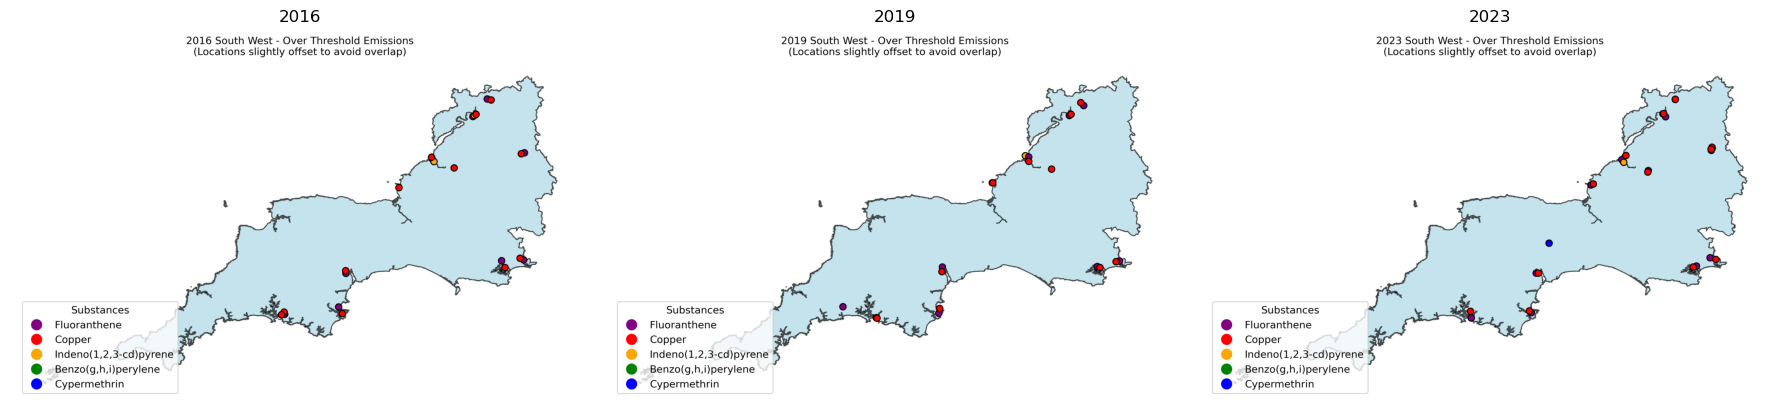

In [18]:


img_2016 = Image.open("Maps_v4/2016_south_west_emissions_map.png")
img_2019 = Image.open("Maps_v4/2019_south_west_emissions_map.png")
img_2023 = Image.open("Maps_v4/2023_south_west_emissions_map.png")

# Display the maps
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  

for ax, img, year in zip(axs, [img_2016, img_2019, img_2023], [2016, 2019, 2023]):
    ax.imshow(img)
    ax.set_title(f"{year}")
    ax.axis("off") 

plt.tight_layout()
plt.show()

### Emission region maps (full version)

In [22]:

# Color mapping
substance_colors = {
    "Fluoranthene": "purple",
    "Copper": "red",
    "Indeno(1,2,3-cd)pyrene": "orange",
    "Benzo(g,h,i)perylene": "green",
    "Cypermethrin": "blue",
}

target_substances = list(substance_colors.keys())
geojson_path = "Regions.geojson"

# Load GeoJSON once
with open(geojson_path, "r", encoding="utf-8") as f:
    geojson_data = json.load(f)

# Function to plot a map for one region and year
def plot_map(csv_file, year, region_name):
    np.random.seed(42)

    # Get geometry for region
    selected_region = next(
        (f for f in geojson_data["features"] if f["properties"].get("RGN24NM") == region_name), None
    )
    if not selected_region:
        print(f"❌ Region '{region_name}' not found.")
        return

    geom = shape(selected_region["geometry"])

    # Load and clean data
    df = pd.read_csv(csv_file)
    df.columns = df.columns.str.strip()
    df["SUBSTANCE NAME"] = df["SUBSTANCE NAME"].str.strip()

    df = df[
        df["SUBSTANCE NAME"].isin(target_substances) &
        df["Latitude"].notna() &
        df["Longitude"].notna() &
        df["REPORTING THRESHOLD (kg)"].notna() &
        df["QUANTITY RELEASED (kg)"].notna()
    ].copy()

    def is_over_threshold_and_in_region(row):
        try:
            qty = float(row["QUANTITY RELEASED (kg)"])
            threshold = float(row["REPORTING THRESHOLD (kg)"])
            point = Point(float(row["Longitude"]), float(row["Latitude"]))
            return qty > threshold and geom.contains(point)
        except:
            return False

    df_filtered = df[df.apply(is_over_threshold_and_in_region, axis=1)]

    # Plot setup
    fig, ax = plt.subplots(figsize=(8, 5))

    if geom.geom_type == "Polygon":
        x, y = geom.exterior.xy
        ax.fill(x, y, color="lightblue", edgecolor="black", alpha=0.7)
    elif geom.geom_type == "MultiPolygon":
        for polygon in geom.geoms:
            x, y = polygon.exterior.xy
            ax.fill(x, y, color="lightblue", edgecolor="black", alpha=0.7)

    ax.set_title(
        f"{year} {region_name} - Over Threshold Emissions\n(Locations slightly offset to avoid overlap)",
        fontsize=10
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

    print(f"\n📍 {year} {region_name} - Plotted points with jitter:")

    for _, row in df_filtered.iterrows():
        substance = row["SUBSTANCE NAME"]
        color = substance_colors.get(substance, "gray")
        lon = float(row["Longitude"])
        lat = float(row["Latitude"])
        lon_jitter = lon + np.random.uniform(-0.03, 0.03)
        lat_jitter = lat + np.random.uniform(-0.03, 0.03)

        ax.scatter(
            lon_jitter,
            lat_jitter,
            marker="o",
            color=color,
            s=40,
            edgecolor="black"
        )
        print(f"  - {substance}: ({lat_jitter:.5f}, {lon_jitter:.5f})")

    # Legend
    legend_handles = [
        plt.Line2D([], [], marker="o", color=color, label=substance, linestyle="None", markersize=8)
        for substance, color in substance_colors.items()
    ]
    ax.legend(handles=legend_handles, title="Substances", loc="lower left")

    # Create output folder
    region_folder = f"Maps_v4/{region_name}"
    os.makedirs(region_folder, exist_ok=True)

    # Save plot
    output_path = f"{region_folder}/{year}_{region_name.lower().replace(' ', '_')}_emissions_map.png"
    plt.savefig(output_path, dpi=300, bbox_inches="tight")

    # Print summary
    print(f"\n{year} {region_name} - Raw point coordinates (before jitter):")
    for i, row in df_filtered.iterrows():
        lat = row["Latitude"]
        lon = row["Longitude"]
        substance = row["SUBSTANCE NAME"]
        print(f"  - {substance}: ({lat:.5f}, {lon:.5f})")

    plt.close()
    print(f"✅ Saved: {output_path}")

# Regions and years to plot
regions_to_plot = [
    "South West",
    "North East",
    "North West",
    "Yorkshire and The Humber",
    "East Midlands",
    "West Midlands",
    "East of England",
    "London",
    "South East"
]

years_and_files = [
    (2016, "Dataset_v4/d16_v4.csv"),
    (2019, "Dataset_v4/d19_v4.csv"),
    (2023, "Dataset_v4/d23_v4.csv")
]

# Loop through all region/year combinations
for region in regions_to_plot:
    for year, file in years_and_files:
        plot_map(file, year, region)


📍 2016 South West - Plotted points with jitter:
  - Fluoranthene: (51.94921, -2.15536)
  - Fluoranthene: (50.37197, -4.09934)
  - Fluoranthene: (50.67047, -3.51135)
  - Fluoranthene: (50.76380, -2.01796)
  - Fluoranthene: (50.76900, -1.80675)
  - Fluoranthene: (50.42449, -3.58126)
  - Fluoranthene: (51.55367, -1.79821)
  - Fluoranthene: (51.82059, -2.29467)
  - Fluoranthene: (51.51307, -2.68680)
  - Indeno(1,2,3-cd)pyrene: (51.82706, -2.27966)
  - Indeno(1,2,3-cd)pyrene: (51.48995, -2.66834)
  - Copper: (51.29901, -3.00228)
  - Copper: (50.38813, -4.10515)
  - Copper: (50.36691, -4.13128)
  - Copper: (50.71461, -1.98590)
  - Copper: (50.37653, -3.54604)
  - Copper: (51.44429, -2.47471)
  - Copper: (51.94067, -2.11990)
  - Copper: (51.54679, -1.82987)
  - Copper: (51.83599, -2.26453)
  - Copper: (50.69082, -3.51339)
  - Copper: (50.78108, -1.84075)
  - Copper: (51.52133, -2.68953)

2016 South West - Raw point coordinates (before jitter):
  - Fluoranthene: (51.92217, -2.14783)
  - Fluor


📍 2023 North East - Plotted points with jitter:
  - Cypermethrin: (54.99542, -1.86114)
  - Fluoranthene: (54.64707, -1.18299)
  - Fluoranthene: (54.46748, -1.57604)
  - Fluoranthene: (54.91804, -1.38800)
  - Fluoranthene: (54.62314, -1.12516)
  - Fluoranthene: (55.01828, -1.50925)
  - Indeno(1,2,3-cd)pyrene: (54.87881, -1.34154)
  - Indeno(1,2,3-cd)pyrene: (54.59166, -1.15031)
  - Indeno(1,2,3-cd)pyrene: (54.99157, -1.49223)
  - Copper: (54.59813, -1.13531)
  - Copper: (54.56535, -1.26924)
  - Copper: (54.62371, -1.21606)
  - Copper: (54.60740, -1.16540)
  - Copper: (54.64200, -1.21493)
  - Copper: (54.46091, -1.54985)
  - Copper: (54.87630, -1.35504)
  - Copper: (54.63758, -1.15732)
  - Copper: (55.00859, -1.45254)

2023 North East - Raw point coordinates (before jitter):
  - Cypermethrin: (54.96837, -1.85361)
  - Fluoranthene: (54.64115, -1.19691)
  - Fluoranthene: (54.48812, -1.55540)
  - Fluoranthene: (54.89607, -1.36149)
  - Fluoranthene: (54.61065, -1.13122)
  - Fluoranthene: (5


2019 North West - Raw point coordinates (before jitter):
  - Indeno(1,2,3-cd)pyrene: (53.42781, -2.99882)
  - Fluoranthene: (53.42781, -2.99882)
  - Fluoranthene: (53.11247, -2.49908)
  - Indeno(1,2,3-cd)pyrene: (53.45781, -2.69695)
  - Fluoranthene: (53.45781, -2.69695)
  - Indeno(1,2,3-cd)pyrene: (53.46264, -2.91468)
  - Fluoranthene: (53.46264, -2.91468)
  - Indeno(1,2,3-cd)pyrene: (53.46427, -2.38104)
  - Fluoranthene: (53.46427, -2.38104)
  - Fluoranthene: (53.47048, -2.37869)
  - Fluoranthene: (53.47813, -2.31427)
  - Indeno(1,2,3-cd)pyrene: (53.40502, -2.20422)
  - Fluoranthene: (53.40502, -2.20422)
  - Indeno(1,2,3-cd)pyrene: (53.53682, -2.34925)
  - Fluoranthene: (53.53682, -2.34925)
  - Indeno(1,2,3-cd)pyrene: (53.56869, -2.29667)
  - Fluoranthene: (53.56869, -2.29667)
  - Indeno(1,2,3-cd)pyrene: (53.53524, -2.16351)
  - Fluoranthene: (53.53524, -2.16351)
  - Indeno(1,2,3-cd)pyrene: (53.60775, -2.18042)
  - Fluoranthene: (53.60775, -2.18042)
  - Indeno(1,2,3-cd)pyrene: (53.3


📍 2016 Yorkshire and The Humber - Plotted points with jitter:
  - Cypermethrin: (53.70746, -1.64566)
  - Cypermethrin: (53.67532, -1.72838)
  - Cypermethrin: (53.73868, -1.80461)
  - Cypermethrin: (53.78049, -1.81110)
  - Cypermethrin: (53.86011, -1.70617)
  - Cypermethrin: (53.59215, -1.83125)
  - Cypermethrin: (53.77306, -1.71135)
  - Cypermethrin: (53.65665, -1.62653)
  - Indeno(1,2,3-cd)pyrene: (53.58272, -0.63177)
  - Cypermethrin: (53.67594, -1.62851)
  - Copper: (53.63906, -1.76112)
  - Copper: (53.63186, -0.26951)
  - Copper: (53.46197, -1.33096)
  - Copper: (53.44579, -1.34886)
  - Copper: (53.62083, -1.77597)
  - Copper: (53.56147, -0.61357)
  - Copper: (53.94170, -1.11260)
  - Copper: (53.71646, -1.83420)
  - Copper: (53.65389, -1.48940)
  - Copper: (53.54451, -1.08338)
  - Copper: (53.36761, -1.37264)
  - Copper: (53.63925, -0.18820)
  - Copper: (53.55283, -0.69864)
  - Copper: (53.75256, -1.76741)
  - Copper: (53.71780, -0.99372)
  - Copper: (53.75533, -0.20870)
  - Coppe


2016 East Midlands - Raw point coordinates (before jitter):
  - Fluoranthene: (52.30880, -0.62047)
  - Fluoranthene: (52.24584, -0.78164)
  - Fluoranthene: (52.98717, -1.42304)
  - Fluoranthene: (52.97343, -1.03752)
  - Fluoranthene: (52.69789, -1.11714)
  - Indeno(1,2,3-cd)pyrene: (52.24584, -0.78164)
  - Indeno(1,2,3-cd)pyrene: (52.98717, -1.42304)
  - Indeno(1,2,3-cd)pyrene: (52.97343, -1.03752)
  - Indeno(1,2,3-cd)pyrene: (52.69789, -1.11714)
  - Copper: (53.26466, -1.41430)
  - Copper: (52.30880, -0.62047)
  - Copper: (53.36393, -0.79927)
  - Copper: (52.98717, -1.42304)
  - Copper: (53.22560, -0.50640)
  - Copper: (52.24584, -0.78164)
  - Copper: (52.69789, -1.11714)
  - Copper: (53.36072, -0.81154)
  - Copper: (53.30334, -0.78177)
  - Copper: (52.97343, -1.03752)
  - Copper: (52.86604, -1.25426)
✅ Saved: Maps_v4/East Midlands/2016_east_midlands_emissions_map.png

📍 2019 East Midlands - Plotted points with jitter:
  - Fluoranthene: (53.25264, -0.51393)
  - Indeno(1,2,3-cd)pyrene


📍 2023 West Midlands - Plotted points with jitter:
  - Fluoranthene: (52.20684, -2.23766)
  - Fluoranthene: (52.26949, -1.58061)
  - Fluoranthene: (52.80827, -1.63219)
  - Fluoranthene: (52.63450, -2.17563)
  - Fluoranthene: (52.52904, -1.71537)
  - Fluoranthene: (52.97752, -2.20985)
  - Fluoranthene: (52.34307, -1.48808)
  - Indeno(1,2,3-cd)pyrene: (52.49756, -1.74053)
  - Fluoranthene: (52.52664, -1.76040)
  - Indeno(1,2,3-cd)pyrene: (52.93680, -2.18517)
  - Indeno(1,2,3-cd)pyrene: (52.33870, -1.50132)
  - Indeno(1,2,3-cd)pyrene: (52.51714, -1.76112)
  - Copper: (52.57938, -2.06661)
  - Copper: (52.50029, -1.96406)
  - Copper: (52.58092, -2.00549)
  - Copper: (52.46858, -1.90293)
  - Copper: (52.63946, -2.17522)
  - Copper: (52.73806, -2.54644)
  - Copper: (52.51701, -1.97039)
  - Copper: (52.35793, -2.24647)
  - Copper: (52.38267, -1.29803)
  - Copper: (52.63961, -1.99703)
  - Copper: (52.18955, -2.24461)
  - Copper: (52.26477, -1.60582)
  - Copper: (52.81000, -1.60875)
  - Copper:


2023 East of England - Raw point coordinates (before jitter):
  - Fluoranthene: (52.10970, 1.08578)
  - Fluoranthene: (51.45290, 0.38297)
  - Fluoranthene: (52.03295, 1.16506)
  - Fluoranthene: (51.74229, 0.66371)
  - Fluoranthene: (51.87446, 0.93668)
  - Fluoranthene: (52.13406, -0.41620)
  - Fluoranthene: (52.23208, 0.17084)
  - Fluoranthene: (51.58489, 0.62417)
  - Fluoranthene: (52.56738, -0.19938)
  - Fluoranthene: (52.61925, 1.36386)
  - Fluoranthene: (51.77495, 0.01706)
  - Fluoranthene: (51.61719, -0.49637)
  - Indeno(1,2,3-cd)pyrene: (52.23208, 0.17084)
  - Indeno(1,2,3-cd)pyrene: (51.58489, 0.62417)
  - Indeno(1,2,3-cd)pyrene: (52.56738, -0.19938)
  - Indeno(1,2,3-cd)pyrene: (52.61925, 1.36386)
  - Indeno(1,2,3-cd)pyrene: (51.77495, 0.01706)
  - Indeno(1,2,3-cd)pyrene: (51.61719, -0.49637)
  - Copper: (52.64514, 1.25820)
  - Copper: (52.13895, 0.50039)
  - Copper: (52.20480, -0.26735)
  - Copper: (52.73381, 0.38603)
  - Copper: (52.56738, -0.19938)
  - Copper: (52.13406, -0.


2016 South East - Raw point coordinates (before jitter):
  - Cypermethrin: (51.32786, 0.44984)
  - Fluoranthene: (50.81828, -0.58904)
  - Fluoranthene: (50.78490, 0.32685)
  - Fluoranthene: (51.32814, -0.76994)
  - Fluoranthene: (51.29188, -1.02619)
  - Fluoranthene: (50.82024, -0.34138)
  - Fluoranthene: (50.85514, 0.51762)
  - Fluoranthene: (51.38498, 0.62781)
  - Fluoranthene: (51.11461, 1.26334)
  - Fluoranthene: (50.66354, -1.14861)
  - Fluoranthene: (50.91157, -1.44878)
  - Fluoranthene: (51.71592, -1.21687)
  - Fluoranthene: (51.57504, -0.73443)
  - Fluoranthene: (52.06443, -0.70854)
  - Fluoranthene: (51.43175, -0.97863)
  - Fluoranthene: (51.50391, -0.64563)
  - Fluoranthene: (50.79597, -0.02481)
  - Fluoranthene: (50.82649, -1.19918)
  - Fluoranthene: (50.84533, -0.99574)
  - Fluoranthene: (51.46788, 0.23876)
  - Indeno(1,2,3-cd)pyrene: (51.71592, -1.21687)
  - Indeno(1,2,3-cd)pyrene: (51.57504, -0.73443)
  - Indeno(1,2,3-cd)pyrene: (52.06443, -0.70854)
  - Indeno(1,2,3-cd)p

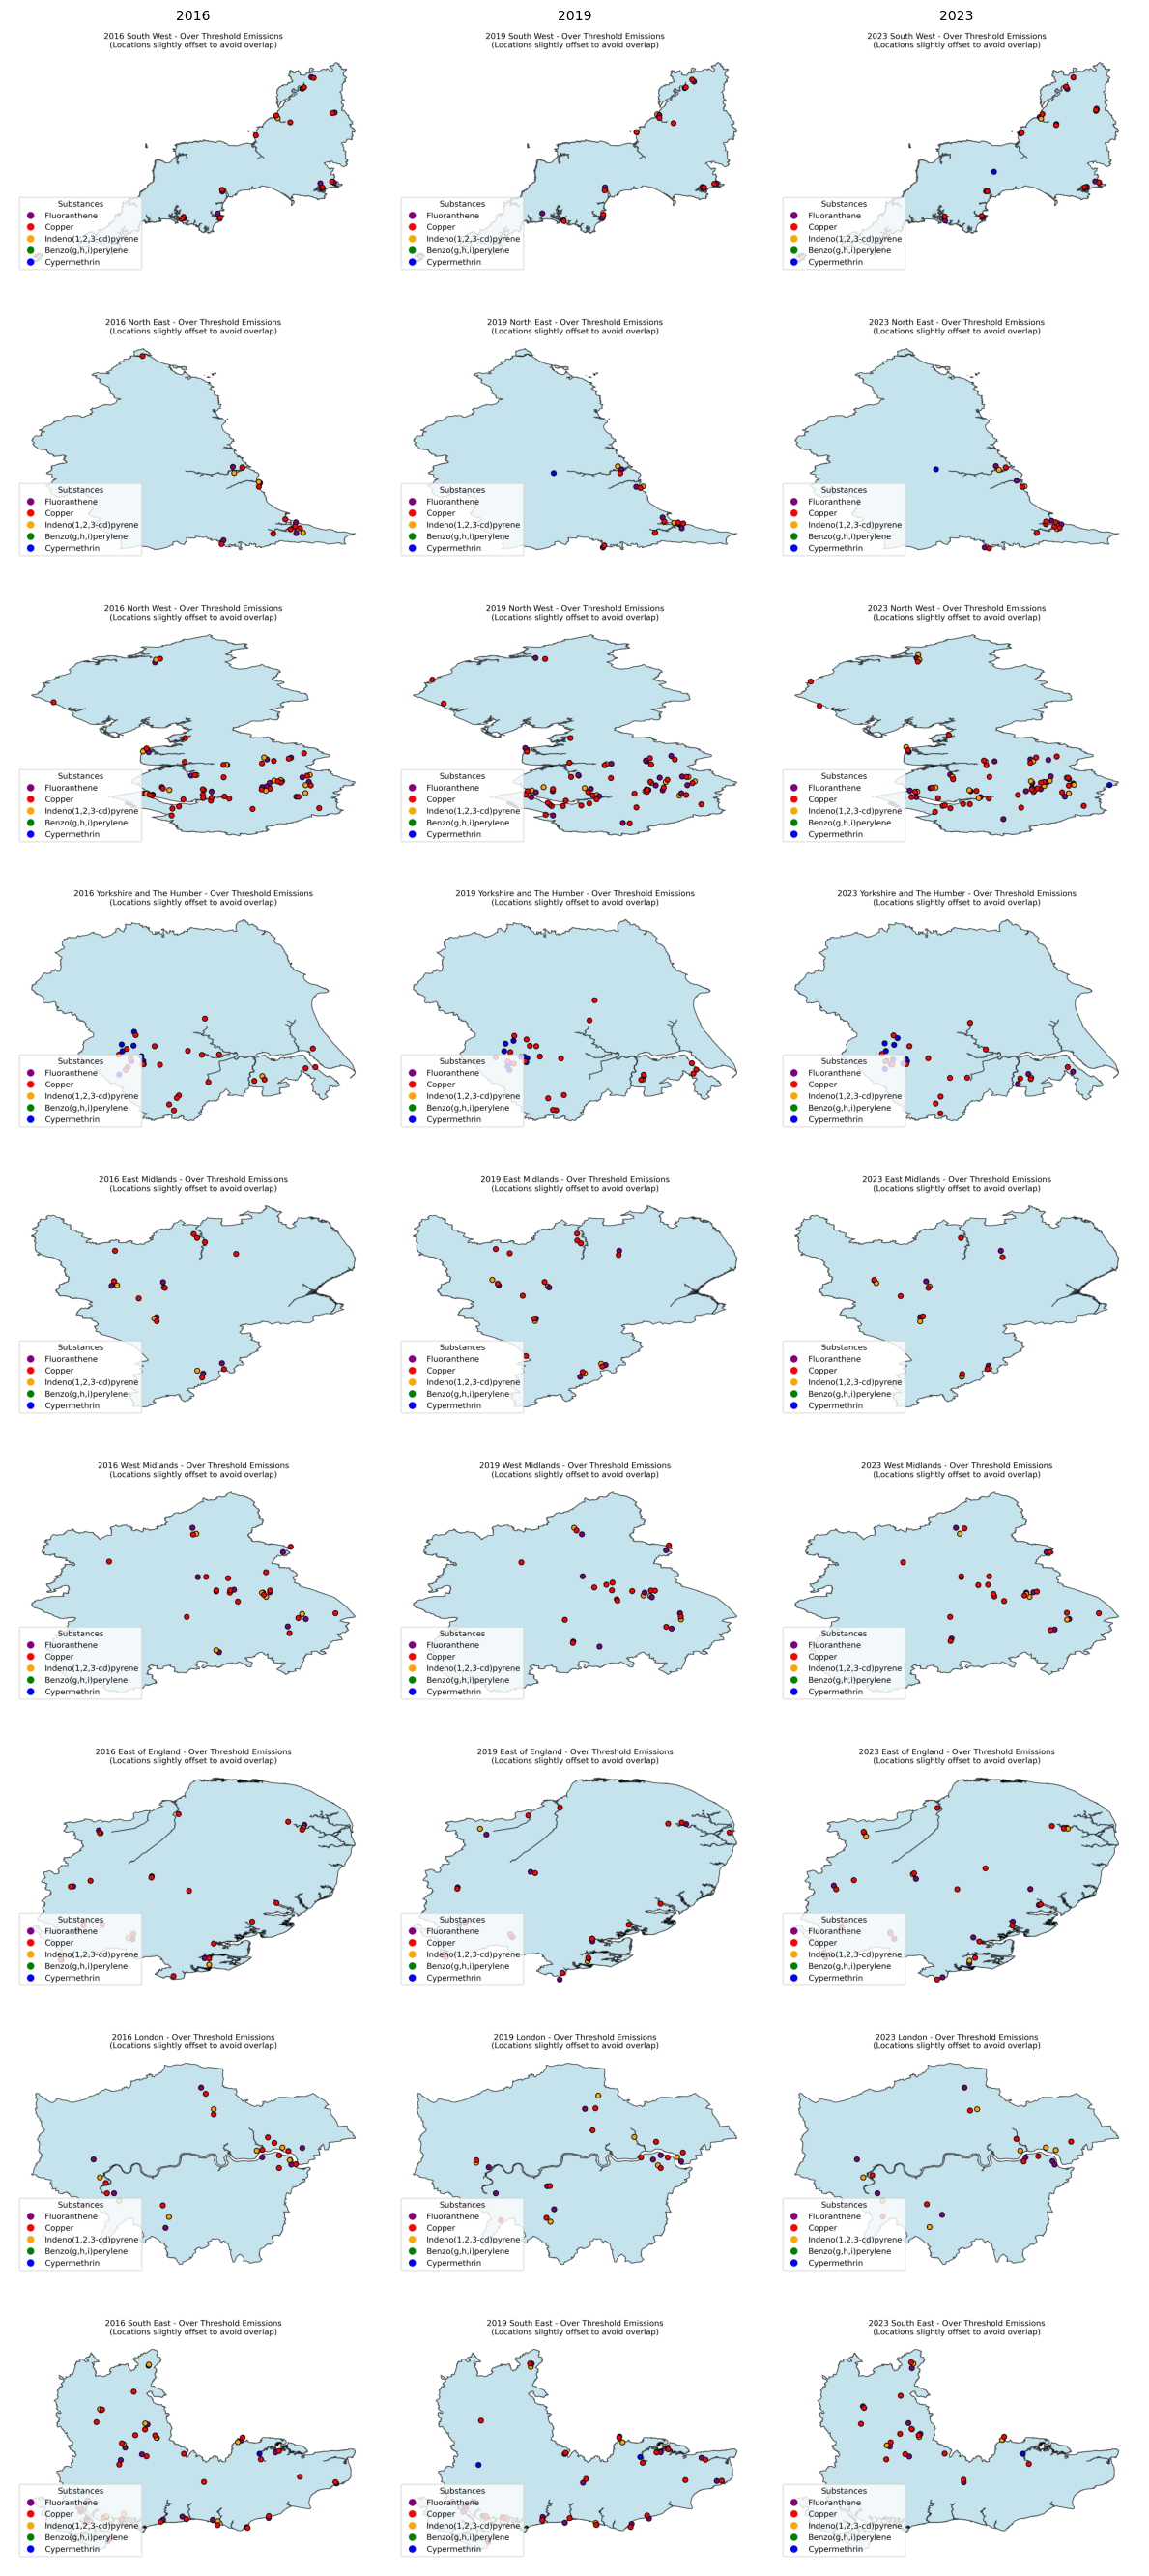

In [23]:

# Set the order of the displayed images
n_regions = len(regions_to_plot)
n_years = len(years_and_files)

fig, axs = plt.subplots(nrows=n_regions, ncols=n_years, figsize=(n_years * 4, n_regions * 3))

for i, region in enumerate(regions_to_plot):
    for j, (year, _) in enumerate(years_and_files):
        # image path
        filename = f"Maps_v4/{region}/{year}_{region.lower().replace(' ', '_')}_emissions_map.png"
        try:
            img = mpimg.imread(filename)
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            if i == 0:
                axs[i, j].set_title(str(year), fontsize=10)
            if j == 0:
                axs[i, j].set_ylabel(region, fontsize=9)
        except FileNotFoundError:
            axs[i, j].text(0.5, 0.5, "Image not found", ha='center', va='center')
            axs[i, j].axis('off')

plt.tight_layout()
plt.show()


### Summary for companies/regions  

In [30]:

summary_records = []

for region in regions_to_plot:
    # load the region geometry
    selected_region = next(
        (f for f in geojson_data["features"] if f["properties"].get("RGN24NM") == region), None
    )
    if not selected_region:
        print(f"⚠️ Region '{region}' not found in GeoJSON")
        continue

    geom = shape(selected_region["geometry"])

    for year, file in years_and_files:
        df = pd.read_csv(file)
        df.columns = df.columns.str.strip()
        df["SUBSTANCE NAME"] = df["SUBSTANCE NAME"].str.strip()

        # Screen the valid data of the target pollutants
        df = df[
            df["SUBSTANCE NAME"].isin(target_substances) &
            df["Latitude"].notna() &
            df["Longitude"].notna() &
            df["REPORTING THRESHOLD (kg)"].notna() &
            df["QUANTITY RELEASED (kg)"].notna()
        ].copy()

        # Determine whether it exceeds the threshold and is in the region
        def is_over_threshold_and_in_region(row):
            try:
                qty = float(row["QUANTITY RELEASED (kg)"])
                threshold = float(row["REPORTING THRESHOLD (kg)"])
                point = Point(float(row["Longitude"]), float(row["Latitude"]))
                return qty > threshold and geom.contains(point)
            except:
                return False

        df_filtered = df[df.apply(is_over_threshold_and_in_region, axis=1)]

        # Group statistics: Pollutants
        grouped = df_filtered.groupby("SUBSTANCE NAME")

        for substance, group in grouped:
            total_emission = group["QUANTITY RELEASED (kg)"].sum()
            operators = group["OPERATOR NAME"].dropna().unique()
            summary_records.append({
                "Year": year,
                "Region": region,
                "SUBSTANCE NAME": substance,
                "Total Emission (kg)": round(total_emission, 2),
                "Quantity of Operators": len(operators),
                "Operators name": "; ".join(operators)
            })

# convert to DataFrame and save
summary_df = pd.DataFrame(summary_records)
summary_df = summary_df.sort_values(by=["Year", "Region", "SUBSTANCE NAME"])

# save the excel file
output_path = "Maps_v4/emission_summary_by_region.xlsx"
os.makedirs("Maps_v4", exist_ok=True)
summary_df.to_excel(output_path, index=False)
print(f"✅ Emission summary saved to: {output_path}")


✅ Emission summary saved to: Maps_v4/emission_summary_by_region.xlsx


In [32]:
# Read the statistical results
summary_df = pd.read_excel("Maps_v4/emission_summary_by_region.xlsx")
summary_df 

,Year,Region,SUBSTANCE NAME,Total Emission (kg),Quantity of Operators,Operators name
0,2016,East Midlands,Copper,3541.13,6,Yorkshire Water Services Limited; Anglian Wate...
1,2016,East Midlands,Fluoranthene,1.69,2,Anglian Water; SEVERN TRENT WATER LTD
2,2016,East Midlands,"Indeno(1,2,3-cd)pyrene",8.93,2,Anglian Water; SEVERN TRENT WATER LTD
3,2016,East of England,Copper,5499.09,7,Anglian Water; GlaxoSmithKline Research and De...
4,2016,East of England,Fluoranthene,1.77,2,Anglian Water; THAMES WATER UTILITIES LTD
...,...,...,...,...,...,...
85,2023,West Midlands,"Indeno(1,2,3-cd)pyrene",16.27,1,SEVERN TRENT WATER LTD
86,2023,Yorkshire and The Humber,Copper,1579.28,7,Yorkshire Water Services Limited; Syngenta Lim...
87,2023,Yorkshire and The Humber,Cypermethrin,12.27,9,Calder Textiles Limited; Huddersfield Dyeing C...
88,2023,Yorkshire and The Humber,Fluoranthene,2.96,3,British Steel Limited; Phillips 66 Limited; SE...


### County level (test for north west)

In [6]:
substance_colors = {
    "Fluoranthene": "purple",
    "Copper": "red",
    "Indeno(1,2,3-cd)pyrene": "orange",
    "Benzo(g,h,i)perylene": "green",
    "Cypermethrin": "blue",
}

target_substances = list(substance_colors.keys())

north_west_counties = [
    "Liverpool", "Cheshire West and Chester", "Cheshire East", "St. Helens", "Trafford",
    "Salford", "Stockport", "Bolton", "Bury", "Oldham", "Rochdale", "Warrington",
    "Wirral", "Lancashire", "Cumberland"
]

# load County GeoJSON
with open("Counties_and_Unitary_Authorities_December_2023_Boundaries_UK_BFC_-4617208807768178004.geojson", "r", encoding="utf-8") as f:
    county_geo = json.load(f)

county_geoms = {
    feature["properties"]["CTYUA23NM"]: shape(feature["geometry"])
    for feature in county_geo["features"]
    if feature["properties"]["CTYUA23NM"] in north_west_counties
}

# Load the GeoJSON of the North West region additionally to supplement the parts not covered by County
with open("Regions.geojson", "r", encoding="utf-8") as f:
    region_geo = json.load(f)

nw_region_feature = next(
    (f for f in region_geo["features"] if f["properties"].get("RGN24NM") == "North West"), None
)
if not nw_region_feature:
    raise ValueError("North West region not found in Regions.geojson")
nw_region_geom = shape(nw_region_feature["geometry"])

years_and_files = [
    (2016, "Dataset_v4/d16_v4.csv"),
    (2019, "Dataset_v4/d19_v4.csv"),
    (2023, "Dataset_v4/d23_v4.csv"),
]

output_dir = "Maps_v4/NorthWest_By_County"
os.makedirs(output_dir, exist_ok=True)

def plot_nw_county_map(csv_file, year):
    np.random.seed(42)
    df = pd.read_csv(csv_file)
    df.columns = df.columns.str.strip()
    df["SUBSTANCE NAME"] = df["SUBSTANCE NAME"].str.strip()

    df = df[
        df["SUBSTANCE NAME"].isin(target_substances) &
        df["Latitude"].notna() &
        df["Longitude"].notna() &
        df["REPORTING THRESHOLD (kg)"].notna() &
        df["QUANTITY RELEASED (kg)"].notna()
    ].copy()

    def match_county(row):
        try:
            point = Point(float(row["Longitude"]), float(row["Latitude"]))
            for name, geom in county_geoms.items():
                if geom.contains(point):
                    return name
        except:
            return None
        return None

    df["County"] = df.apply(match_county, axis=1)

    df = df[df["County"].notna()]
    df = df[
        df["QUANTITY RELEASED (kg)"].astype(float) > df["REPORTING THRESHOLD (kg)"].astype(float)
    ]

    counties_with_emissions = df["County"].unique()

    fig, ax = plt.subplots(figsize=(10, 10))

    # First, draw the boundary of the North West region as a supplementary base map (filled in light gray, borderless)
    if nw_region_geom.geom_type == "Polygon":
        x, y = nw_region_geom.exterior.xy
        ax.fill(x, y, color="lightgray", alpha=0.3, zorder=0)
    elif nw_region_geom.geom_type == "MultiPolygon":
        for part in nw_region_geom.geoms:
            x, y = part.exterior.xy
            ax.fill(x, y, color="lightgray", alpha=0.3, zorder=0)

    # Draw the County boundaries and fill, and only draw the counties with emission data
    for name, geom in county_geoms.items():
        if name in counties_with_emissions:
            if geom.geom_type == "Polygon":
                x, y = geom.exterior.xy
                ax.plot(x, y, color="black", linewidth=0.8, zorder=2)
                ax.fill(x, y, color="lightblue", alpha=0.2, zorder=1)
            elif geom.geom_type == "MultiPolygon":
                for part in geom.geoms:
                    x, y = part.exterior.xy
                    ax.plot(x, y, color="black", linewidth=0.8, zorder=2)
                    ax.fill(x, y, color="lightblue", alpha=0.2, zorder=1)

            # Only calculate the center point of the entire County's geometry once and mark it once
            centroid = geom.centroid
            ax.text(centroid.x, centroid.y, name, fontsize=8, ha="center", va="center", zorder=3)


    # Draw the discharge points and jitter slightly to avoid overlapping
    for _, row in df.iterrows():
        substance = row["SUBSTANCE NAME"]
        color = substance_colors.get(substance, "gray")
        lon = float(row["Longitude"]) + np.random.uniform(-0.02, 0.02)
        lat = float(row["Latitude"]) + np.random.uniform(-0.02, 0.02)
        ax.scatter(lon, lat, color=color, s=40, edgecolor="black", zorder=4)

    ax.set_title(f"{year} North West - County Level Emissions (with region fill and county labels)", fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

    legend_handles = [
        plt.Line2D([], [], marker="o", color=color, label=substance, linestyle="None", markersize=10)
        for substance, color in substance_colors.items()
    ]
    ax.legend(handles=legend_handles, title="Substances", loc="lower left")

    output_path = f"{output_dir}/north_west_{year}_county_emissions_with_region.png"
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"✅ Saved: {output_path}")

for year, csv_file in years_and_files:
    plot_nw_county_map(csv_file, year)

✅ Saved: Maps_v4/NorthWest_By_County/north_west_2016_county_emissions_with_region.png
✅ Saved: Maps_v4/NorthWest_By_County/north_west_2019_county_emissions_with_region.png
✅ Saved: Maps_v4/NorthWest_By_County/north_west_2023_county_emissions_with_region.png


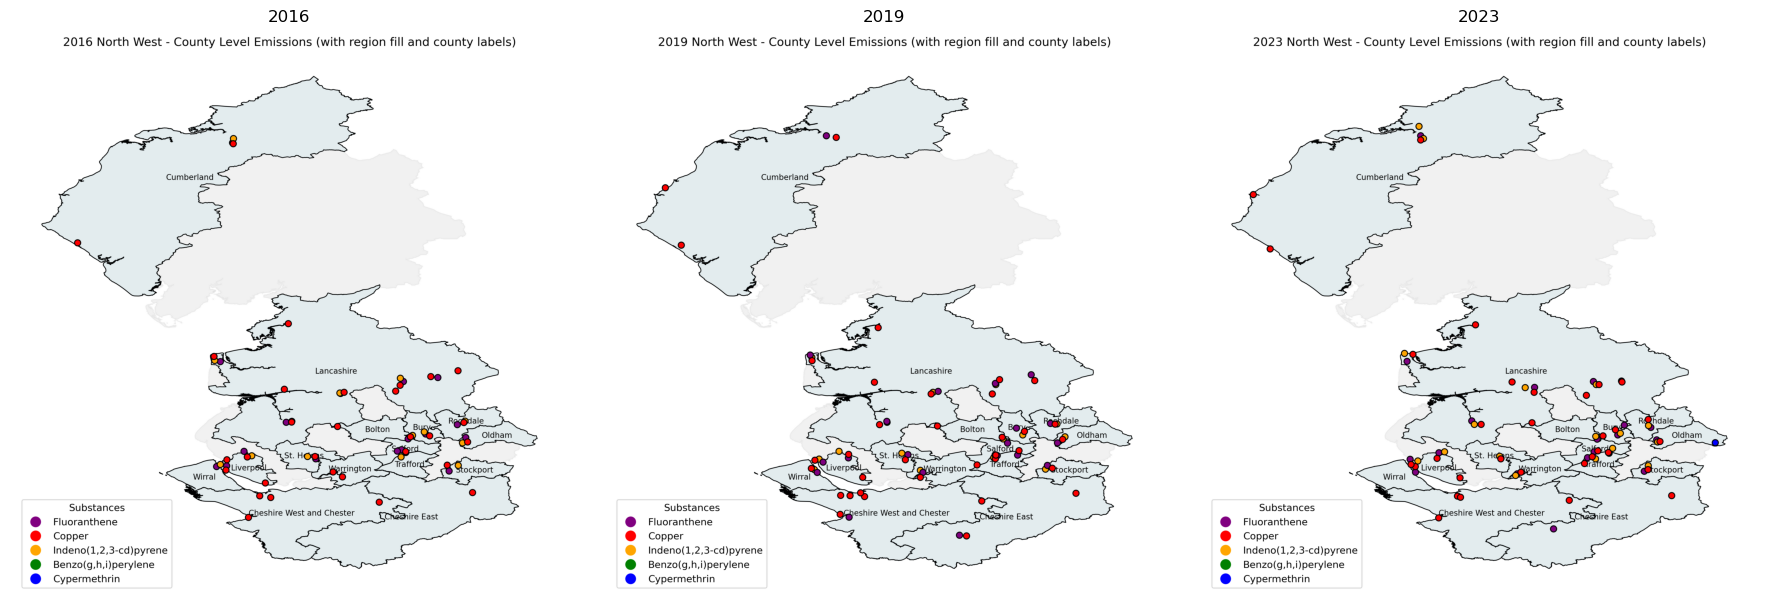

In [16]:
img_2016 = Image.open("Maps_v4/NorthWest_By_County/north_west_2016_county_emissions_with_region.png")
img_2019 = Image.open("Maps_v4/NorthWest_By_County/north_west_2019_county_emissions_with_region.png")
img_2023 = Image.open("Maps_v4/NorthWest_By_County/north_west_2023_county_emissions_with_region.png")

# Display the maps
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  

for ax, img, year in zip(axs, [img_2016, img_2019, img_2023], [2016, 2019, 2023]):
    ax.imshow(img)
    ax.set_title(f"{year}")
    ax.axis("off") 

plt.tight_layout()
plt.show()

In [7]:
substance_colors = {
    "Fluoranthene": "purple",
    "Copper": "red",
    "Indeno(1,2,3-cd)pyrene": "orange",
    "Benzo(g,h,i)perylene": "green",
    "Cypermethrin": "blue",
}

target_substances = list(substance_colors.keys())

Yorkshire_and_the_Humber_counties = [
    "North Lincolnshire", "Kirklees", "Bradford", "Leeds", "Doncaster",
    "Wakefield", "Sheffield", "East Riding of Yorkshire", "Rotherham", "North Yorkshire"
]

# load County GeoJSON
with open("Counties_and_Unitary_Authorities_December_2023_Boundaries_UK_BFC_-4617208807768178004.geojson", "r", encoding="utf-8") as f:
    county_geo = json.load(f)

county_geoms = {
    feature["properties"]["CTYUA23NM"]: shape(feature["geometry"])
    for feature in county_geo["features"]
    if feature["properties"]["CTYUA23NM"] in Yorkshire_and_the_Humber_counties
}

# Load the GeoJSON of the North West region additionally to supplement the parts not covered by County
with open("Regions.geojson", "r", encoding="utf-8") as f:
    region_geo = json.load(f)

nw_region_feature = next(
    (f for f in region_geo["features"] if f["properties"].get("RGN24NM") == "Yorkshire and The Humber"), None
)
if not nw_region_feature:
    raise ValueError("Yorkshire and the Humber region not found in Regions.geojson")
nw_region_geom = shape(nw_region_feature["geometry"])

years_and_files = [
    (2016, "Dataset_v4/d16_v4.csv"),
    (2019, "Dataset_v4/d19_v4.csv"),
    (2023, "Dataset_v4/d23_v4.csv"),
]

output_dir = "Maps_v4/Yorkshire_and_the_Humber_By_County"
os.makedirs(output_dir, exist_ok=True)

def plot_nw_county_map(csv_file, year):
    np.random.seed(42)
    df = pd.read_csv(csv_file)
    df.columns = df.columns.str.strip()
    df["SUBSTANCE NAME"] = df["SUBSTANCE NAME"].str.strip()

    df = df[
        df["SUBSTANCE NAME"].isin(target_substances) &
        df["Latitude"].notna() &
        df["Longitude"].notna() &
        df["REPORTING THRESHOLD (kg)"].notna() &
        df["QUANTITY RELEASED (kg)"].notna()
    ].copy()

    def match_county(row):
        try:
            point = Point(float(row["Longitude"]), float(row["Latitude"]))
            for name, geom in county_geoms.items():
                if geom.contains(point):
                    return name
        except:
            return None
        return None

    df["County"] = df.apply(match_county, axis=1)

    df = df[df["County"].notna()]
    df = df[
        df["QUANTITY RELEASED (kg)"].astype(float) > df["REPORTING THRESHOLD (kg)"].astype(float)
    ]

    counties_with_emissions = df["County"].unique()

    fig, ax = plt.subplots(figsize=(10, 10))

    # First, draw the boundary of the North West region as a supplementary base map (filled in light gray, borderless)
    if nw_region_geom.geom_type == "Polygon":
        x, y = nw_region_geom.exterior.xy
        ax.fill(x, y, color="lightgray", alpha=0.3, zorder=0)
    elif nw_region_geom.geom_type == "MultiPolygon":
        for part in nw_region_geom.geoms:
            x, y = part.exterior.xy
            ax.fill(x, y, color="lightgray", alpha=0.3, zorder=0)

    # Draw the County boundaries and fill, and only draw the counties with emission data
    for name, geom in county_geoms.items():
        if name in counties_with_emissions:
            if geom.geom_type == "Polygon":
                x, y = geom.exterior.xy
                ax.plot(x, y, color="black", linewidth=0.8, zorder=2)
                ax.fill(x, y, color="lightblue", alpha=0.2, zorder=1)
            elif geom.geom_type == "MultiPolygon":
                for part in geom.geoms:
                    x, y = part.exterior.xy
                    ax.plot(x, y, color="black", linewidth=0.8, zorder=2)
                    ax.fill(x, y, color="lightblue", alpha=0.2, zorder=1)

            # Only calculate the center point of the entire County's geometry once and mark it once
            centroid = geom.centroid
            ax.text(centroid.x, centroid.y, name, fontsize=8, ha="center", va="center", zorder=3)


    # Draw the discharge points and jitter slightly to avoid overlapping
    for _, row in df.iterrows():
        substance = row["SUBSTANCE NAME"]
        color = substance_colors.get(substance, "gray")
        lon = float(row["Longitude"]) + np.random.uniform(-0.02, 0.02)
        lat = float(row["Latitude"]) + np.random.uniform(-0.02, 0.02)
        ax.scatter(lon, lat, color=color, s=40, edgecolor="black", zorder=4)

    ax.set_title(f"{year} Yorkshire_and_the_Humber - County Level Emissions (with region fill and county labels)", fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

    legend_handles = [
        plt.Line2D([], [], marker="o", color=color, label=substance, linestyle="None", markersize=10)
        for substance, color in substance_colors.items()
    ]
    ax.legend(handles=legend_handles, title="Substances", loc="lower left")

    output_path = f"{output_dir}/Yorkshire_and_the_Humber_{year}_county_emissions_with_region.png"
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"✅ Saved: {output_path}")

for year, csv_file in years_and_files:
    plot_nw_county_map(csv_file, year)

✅ Saved: Maps_v4/Yorkshire_and_the_Humber_By_County/Yorkshire_and_the_Humber_2016_county_emissions_with_region.png
✅ Saved: Maps_v4/Yorkshire_and_the_Humber_By_County/Yorkshire_and_the_Humber_2019_county_emissions_with_region.png
✅ Saved: Maps_v4/Yorkshire_and_the_Humber_By_County/Yorkshire_and_the_Humber_2023_county_emissions_with_region.png


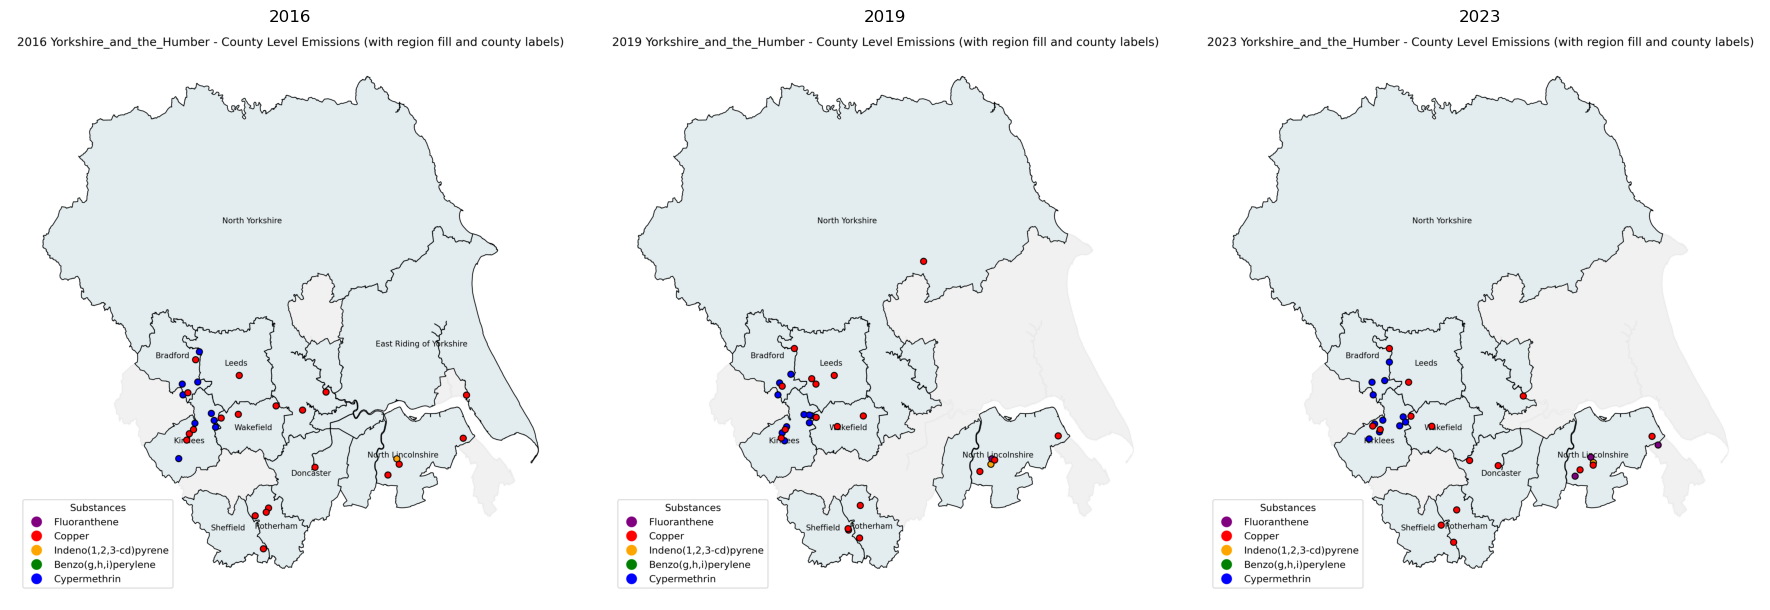

In [15]:
img_2016 = Image.open("Maps_v4/Yorkshire_and_the_Humber_By_County/Yorkshire_and_the_Humber_2016_county_emissions_with_region.png")
img_2019 = Image.open("Maps_v4/Yorkshire_and_the_Humber_By_County/Yorkshire_and_the_Humber_2019_county_emissions_with_region.png")
img_2023 = Image.open("Maps_v4/Yorkshire_and_the_Humber_By_County/Yorkshire_and_the_Humber_2023_county_emissions_with_region.png")

# Display the maps
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  

for ax, img, year in zip(axs, [img_2016, img_2019, img_2023], [2016, 2019, 2023]):
    ax.imshow(img)
    ax.set_title(f"{year}")
    ax.axis("off") 

plt.tight_layout()
plt.show()

In [17]:
substance_colors = {
    "Fluoranthene": "purple",
    "Copper": "red",
    "Indeno(1,2,3-cd)pyrene": "orange",
    "Benzo(g,h,i)perylene": "green",
    "Cypermethrin": "blue",
}

target_substances = list(substance_colors.keys())

london_counties = [
    "Ealing", "Kingston upon Thames", "Bexley", "Newham", "Enfield",
    "Barking and Dagenham", "Lewisham", "Hillingdon", "Havering"
]

# load County GeoJSON
with open("Counties_and_Unitary_Authorities_December_2023_Boundaries_UK_BFC_-4617208807768178004.geojson", "r", encoding="utf-8") as f:
    county_geo = json.load(f)

county_geoms = {
    feature["properties"]["CTYUA23NM"]: shape(feature["geometry"])
    for feature in county_geo["features"]
    if feature["properties"]["CTYUA23NM"] in london_counties
}

# Load the GeoJSON of the North West region additionally to supplement the parts not covered by County
with open("Regions.geojson", "r", encoding="utf-8") as f:
    region_geo = json.load(f)

nw_region_feature = next(
    (f for f in region_geo["features"] if f["properties"].get("RGN24NM") == "London"), None
)
if not nw_region_feature:
    raise ValueError("London region not found in Regions.geojson")
nw_region_geom = shape(nw_region_feature["geometry"])

years_and_files = [
    (2016, "Dataset_v4/d16_v4.csv"),
    (2019, "Dataset_v4/d19_v4.csv"),
    (2023, "Dataset_v4/d23_v4.csv"),
]

output_dir = "Maps_v4/London_By_County"
os.makedirs(output_dir, exist_ok=True)

def plot_nw_county_map(csv_file, year):
    np.random.seed(42)
    df = pd.read_csv(csv_file)
    df.columns = df.columns.str.strip()
    df["SUBSTANCE NAME"] = df["SUBSTANCE NAME"].str.strip()

    df = df[
        df["SUBSTANCE NAME"].isin(target_substances) &
        df["Latitude"].notna() &
        df["Longitude"].notna() &
        df["REPORTING THRESHOLD (kg)"].notna() &
        df["QUANTITY RELEASED (kg)"].notna()
    ].copy()

    def match_county(row):
        try:
            point = Point(float(row["Longitude"]), float(row["Latitude"]))
            for name, geom in county_geoms.items():
                if geom.contains(point):
                    return name
        except:
            return None
        return None

    df["County"] = df.apply(match_county, axis=1)

    df = df[df["County"].notna()]
    df = df[
        df["QUANTITY RELEASED (kg)"].astype(float) > df["REPORTING THRESHOLD (kg)"].astype(float)
    ]

    counties_with_emissions = df["County"].unique()

    fig, ax = plt.subplots(figsize=(10, 10))

    # First, draw the boundary of the North West region as a supplementary base map (filled in light gray, borderless)
    if nw_region_geom.geom_type == "Polygon":
        x, y = nw_region_geom.exterior.xy
        ax.fill(x, y, color="lightgray", alpha=0.3, zorder=0)
    elif nw_region_geom.geom_type == "MultiPolygon":
        for part in nw_region_geom.geoms:
            x, y = part.exterior.xy
            ax.fill(x, y, color="lightgray", alpha=0.3, zorder=0)

    # Draw the County boundaries and fill, and only draw the counties with emission data
    for name, geom in county_geoms.items():
        if name in counties_with_emissions:
            if geom.geom_type == "Polygon":
                x, y = geom.exterior.xy
                ax.plot(x, y, color="black", linewidth=0.8, zorder=2)
                ax.fill(x, y, color="lightblue", alpha=0.2, zorder=1)
            elif geom.geom_type == "MultiPolygon":
                for part in geom.geoms:
                    x, y = part.exterior.xy
                    ax.plot(x, y, color="black", linewidth=0.8, zorder=2)
                    ax.fill(x, y, color="lightblue", alpha=0.2, zorder=1)

            # Only calculate the center point of the entire County's geometry once and mark it once
            centroid = geom.centroid
            ax.text(centroid.x, centroid.y, name, fontsize=8, ha="center", va="center", zorder=3)


    # Draw the discharge points and jitter slightly to avoid overlapping
    for _, row in df.iterrows():
        substance = row["SUBSTANCE NAME"]
        color = substance_colors.get(substance, "gray")
        lon = float(row["Longitude"]) + np.random.uniform(-0.02, 0.02)
        lat = float(row["Latitude"]) + np.random.uniform(-0.02, 0.02)
        ax.scatter(lon, lat, color=color, s=40, edgecolor="black", zorder=4)

    ax.set_title(f"{year} London - County Level Emissions (with region fill and county labels)", fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

    legend_handles = [
        plt.Line2D([], [], marker="o", color=color, label=substance, linestyle="None", markersize=10)
        for substance, color in substance_colors.items()
    ]
    ax.legend(handles=legend_handles, title="Substances", loc="lower left")

    output_path = f"{output_dir}/London_{year}_county_emissions_with_region.png"
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"✅ Saved: {output_path}")

for year, csv_file in years_and_files:
    plot_nw_county_map(csv_file, year)

✅ Saved: Maps_v4/London_By_County/London_2016_county_emissions_with_region.png
✅ Saved: Maps_v4/London_By_County/London_2019_county_emissions_with_region.png
✅ Saved: Maps_v4/London_By_County/London_2023_county_emissions_with_region.png


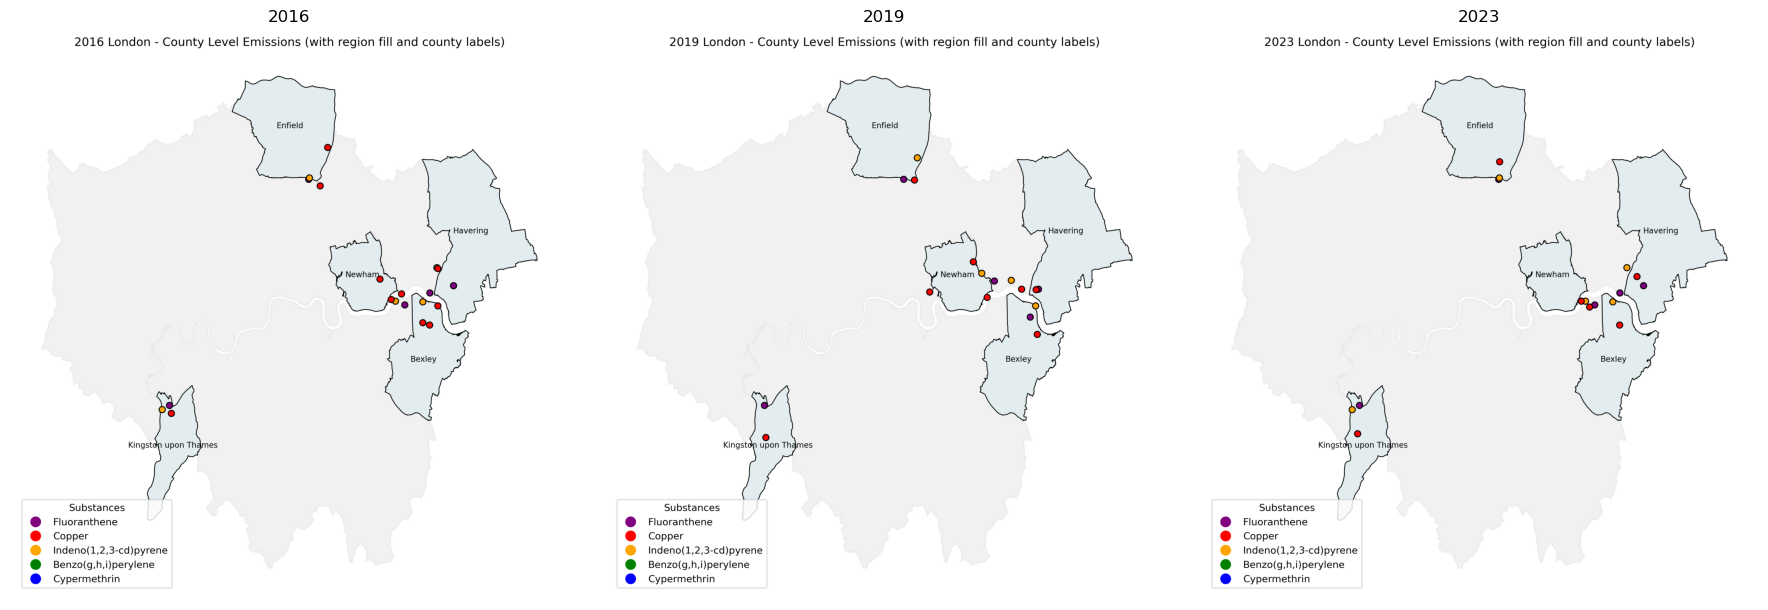

In [19]:
img_2016 = Image.open("Maps_v4/London_By_County/London_2016_county_emissions_with_region.png")
img_2019 = Image.open("Maps_v4/London_By_County/London_2019_county_emissions_with_region.png")
img_2023 = Image.open("Maps_v4/London_By_County/London_2023_county_emissions_with_region.png")

# Display the maps
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  

for ax, img, year in zip(axs, [img_2016, img_2019, img_2023], [2016, 2019, 2023]):
    ax.imshow(img)
    ax.set_title(f"{year}")
    ax.axis("off") 

plt.tight_layout()
plt.show()

In [23]:
# Path to county GeoJSON
geojson_path = "Counties_and_Unitary_Authorities_December_2023_Boundaries_UK_BFC_-4617208807768178004.geojson"

# Load GeoJSON
with open(geojson_path, "r", encoding="utf-8") as f:
    geojson_data = json.load(f)

# Target counties
target_counties = ["Wakefield", "Kirklees", "Newham"]

# Create output directory
os.makedirs("Maps_County", exist_ok=True)

def plot_county_map(csv_file, year, county_name):
    np.random.seed(42)
    
    # Get county geometry
    selected_feature = next(
        (f for f in geojson_data["features"] if f["properties"].get("CTYUA23NM") == county_name), None
    )
    if not selected_feature:
        print(f"County '{county_name}' not found.")
        return
    
    geom = shape(selected_feature["geometry"])
    
    # Load CSV
    df = pd.read_csv(csv_file)
    df.columns = df.columns.str.strip()
    df["SUBSTANCE NAME"] = df["SUBSTANCE NAME"].str.strip()
    
    # Filter
    df = df[
        df["SUBSTANCE NAME"].isin(target_substances) &
        df["Latitude"].notna() &
        df["Longitude"].notna() &
        df["REPORTING THRESHOLD (kg)"].notna() &
        df["QUANTITY RELEASED (kg)"].notna()
    ].copy()
    
    # Filter by threshold and geometry
    def is_valid(row):
        try:
            qty = float(row["QUANTITY RELEASED (kg)"])
            threshold = float(row["REPORTING THRESHOLD (kg)"])
            point = Point(float(row["Longitude"]), float(row["Latitude"]))
            return qty > threshold and geom.contains(point)
        except:
            return False

    df_filtered = df[df.apply(is_valid, axis=1)]
    
    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    if geom.geom_type == "Polygon":
        x, y = geom.exterior.xy
        ax.fill(x, y, color="lightgray", edgecolor="black", alpha=0.5)
    elif geom.geom_type == "MultiPolygon":
        for polygon in geom.geoms:
            x, y = polygon.exterior.xy
            ax.fill(x, y, color="lightgray", edgecolor="black", alpha=0.5)
    
    ax.set_title(f"{year} {county_name} - Over Threshold Emissions\n(Coordinates jittered)", fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

    print(f"\n📍 {year} {county_name} - Plotted points:")
    
    for _, row in df_filtered.iterrows():
        substance = row["SUBSTANCE NAME"]
        color = substance_colors.get(substance, "gray")
        lon = float(row["Longitude"]) + np.random.uniform(-0.005, 0.005)
        lat = float(row["Latitude"]) + np.random.uniform(-0.005, 0.005)
        ax.scatter(lon, lat, marker="o", color=color, s=40, edgecolor="black")
        print(f"  - {substance}: ({lat:.5f}, {lon:.5f})")

    # Legend
    legend_handles = [
        plt.Line2D([], [], marker="o", color=color, label=sub, linestyle="None", markersize=8)
        for sub, color in substance_colors.items()
    ]
    ax.legend(handles=legend_handles, title="Substances", loc="lower left")
    
    output_file = f"Maps_County/{year}_{county_name.replace(' ', '_')}_map.png"
    plt.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"✅ Saved: {output_file}")

# Files to process
datasets = {
    2016: "Dataset_v4/d16_v4.csv",
    2019: "Dataset_v4/d19_v4.csv",
    2023: "Dataset_v4/d23_v4.csv"
}

# Loop through counties and years
for county in target_counties:
    for year, file_path in datasets.items():
        plot_county_map(file_path, year, county)



📍 2016 Wakefield - Plotted points:
  - Cypermethrin: (53.68015, -1.60869)
  - Copper: (53.67901, -1.47536)
  - Copper: (53.71330, -1.28517)
  - Copper: (53.67931, -1.61186)
✅ Saved: Maps_County/2016_Wakefield_map.png

📍 2019 Wakefield - Plotted points:
  - Cypermethrin: (53.68015, -1.60869)
  - Copper: (53.67901, -1.47536)
  - Copper: (53.67220, -1.61088)
  - Copper: (53.69562, -1.32095)
✅ Saved: Maps_County/2019_Wakefield_map.png

📍 2023 Wakefield - Plotted points:
  - Cypermethrin: (53.68015, -1.60869)
  - Copper: (53.59211, -1.27142)
  - Copper: (53.67459, -1.48112)
  - Copper: (53.67931, -1.61186)
✅ Saved: Maps_County/2023_Wakefield_map.png

📍 2016 Kirklees - Plotted points:
  - Cypermethrin: (53.68492, -1.63938)
  - Cypermethrin: (53.67038, -1.73998)
  - Cypermethrin: (53.56051, -1.80592)
  - Cypermethrin: (53.69212, -1.62885)
  - Copper: (53.66277, -1.76682)
  - Copper: (53.65274, -1.78631)
  - Copper: (53.66652, -1.73897)
✅ Saved: Maps_County/2016_Kirklees_map.png

📍 2019 Kirkl

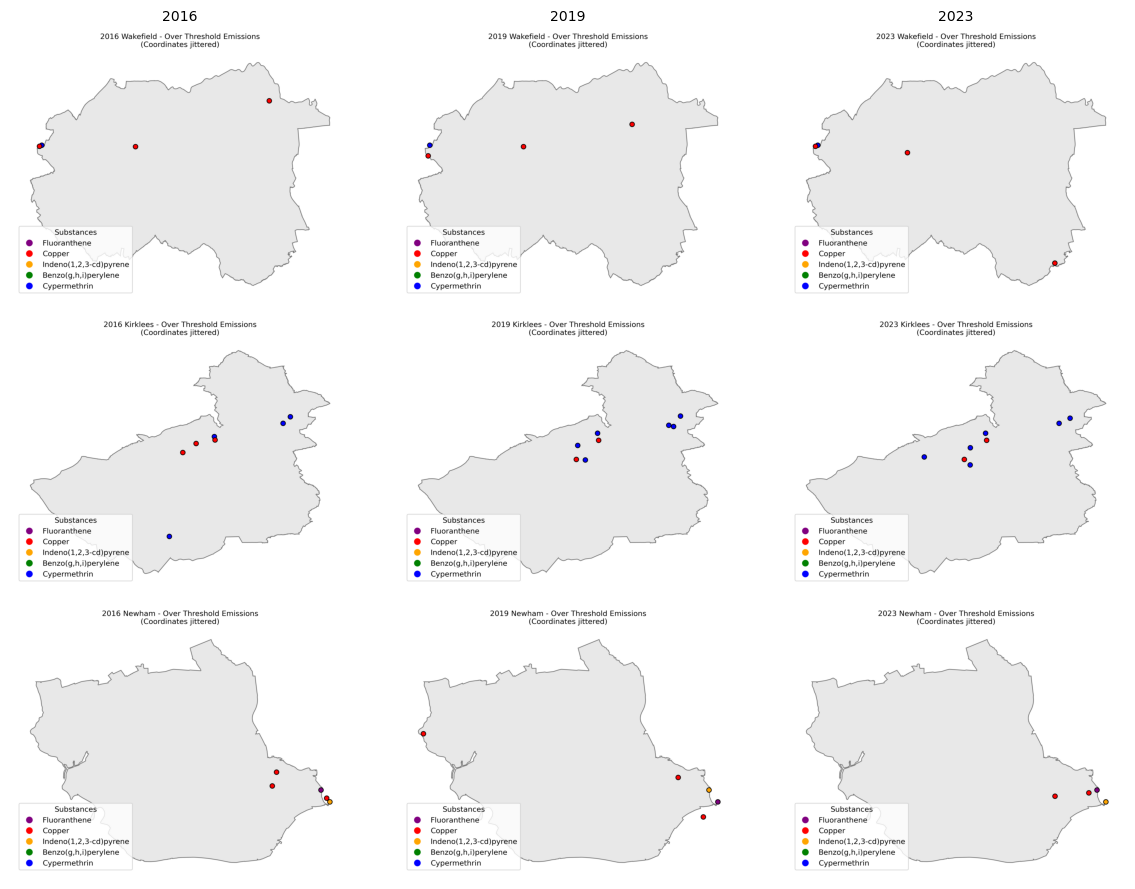

In [24]:
# set the county and year
counties_to_plot = ["Wakefield", "Kirklees", "Newham"]
years = [2016, 2019, 2023]

n_counties = len(counties_to_plot)
n_years = len(years)

fig, axs = plt.subplots(nrows=n_counties, ncols=n_years, figsize=(n_years * 4, n_counties * 3))

# Traverse each county and year, read and display the images
for i, county in enumerate(counties_to_plot):
    for j, year in enumerate(years):
        filename = f"Maps_County/{year}_{county.replace(' ', '_')}_map.png"
        try:
            img = mpimg.imread(filename)
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            if i == 0:
                axs[i, j].set_title(str(year), fontsize=10)
            if j == 0:
                axs[i, j].set_ylabel(county, fontsize=9)
        except FileNotFoundError:
            axs[i, j].text(0.5, 0.5, "Image not found", ha='center', va='center')
            axs[i, j].axis('off')

plt.tight_layout()
plt.show()